### Import the library

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Implement the Actor Networks

In [2]:
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

### Implement Critic Networks

In [3]:
class CriticNetwork(nn.Module):
    def __init__(self, state_dim):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Function for Training Loop

In [4]:
def train_actor_critic_model(env, actor, critic, num_episodes=1000, gamma=0.99, lr=0.001):
    actor_optimizer = optim.Adam(actor.parameters(), lr=lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=lr)
    
    all_episode_rewards = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        episode_reward = 0
        
        while True:
            action_probs = actor(state_tensor)
            action = np.random.choice(len(action_probs.detach().numpy().flatten()), p=action_probs.detach().numpy().flatten())
            
            next_state, reward, done, _, _ = env.step(action)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            episode_reward += reward
            
            # calculate advantage
            value = critic(state_tensor)
            next_value = critic(next_state_tensor)
            advantage = reward + (1 - done) * gamma * next_value - value
            
            # Update actor and critic
            actor_loss = -torch.log(action_probs[0, action]) * advantage.detach()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()
            critic_loss = advantage.pow(2).mean()
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()
            
            state_tensor = next_state_tensor
            
            if done:
                break
        
        all_episode_rewards.append(episode_reward)
        
        if (episode + 1) % 10 == 0:
            print(f'Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}')
    
    return all_episode_rewards



###  Define function for evaluation and testing

In [5]:
def evaluate_actor_critic_model(env, actor, num_episodes=100):
    evaluation_rewards = []
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        
        episode_reward = 0
        
        while True:
            action_probs = actor(state_tensor)
            action = np.argmax(action_probs.detach().numpy())
            
            next_state, reward, done, _, _ = env.step(action)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            episode_reward += reward
            state_tensor = next_state_tensor
            
            if done:
                break
        
        evaluation_rewards.append(episode_reward)
    
    return evaluation_rewards


def plot_actor_critic_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Learning Curve')
    plt.show()



### Train and Evaluate the Model

In [6]:
env = gym.make('LunarLander-v2')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n



actor_network = ActorNetwork(state_dim, action_dim)
critic_network = CriticNetwork(state_dim)

Episode 10/1000, Reward: -671.3026210524218
Episode 20/1000, Reward: -230.6053377391819
Episode 30/1000, Reward: -180.39467299695852
Episode 40/1000, Reward: -64.6491925518219
Episode 50/1000, Reward: -231.35349362422505
Episode 60/1000, Reward: -29.36988716023224
Episode 70/1000, Reward: 244.0090194625898
Episode 80/1000, Reward: -227.8043838974017
Episode 90/1000, Reward: -225.45935636845508
Episode 100/1000, Reward: -54.00508630374365
Episode 110/1000, Reward: 195.53104746291956
Episode 120/1000, Reward: 269.32113076986366
Episode 130/1000, Reward: 5.370921880957582
Episode 140/1000, Reward: 168.88851335963747
Episode 150/1000, Reward: 8.294837306325306
Episode 160/1000, Reward: 183.98417466750203
Episode 170/1000, Reward: 207.29488381889277
Episode 180/1000, Reward: 243.93197668495134
Episode 190/1000, Reward: 168.43825712212077
Episode 200/1000, Reward: -123.97952906004886
Episode 210/1000, Reward: 181.01025931364023
Episode 220/1000, Reward: 141.09822673068464
Episode 230/1000, R

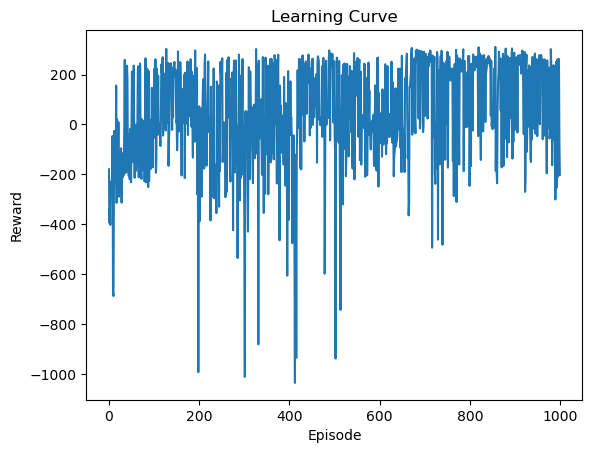

In [16]:
# Train the actor-critic model
episode_rewards = train_actor_critic_model(env, actor_network, critic_network, num_episodes=1000)

# Plot the learning curve
plot_actor_critic_rewards(episode_rewards)

# Save the trained actor model
torch.save(actor_network.state_dict(), 'actor_network_model.pth')

### Observation

As per the learning curve above, the initial episodes having significant amount of negative rewards which indicates that the model was learning to interact with the environment. As training process progresses, the rewards show less variability and more stability but there are still variation which indicates that the Actor-Critic model is improving its policy over time.

### Load the trained actor model

In [7]:
actor_network = ActorNetwork(state_dim, action_dim)
actor_network.load_state_dict(torch.load('actor_network_model.pth'))
actor_network.eval()  

ActorNetwork(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=-1)
)

### Play an episode

In [8]:
def play_lander_episode_with_actor(env, actor):
    state, _ = env.reset()
    state_tensor = torch.FloatTensor(state).unsqueeze(0)

    episode_reward = 0
    done = False

    while not done:
        env.render()  # Render the environment
        action_probs = actor(state_tensor)
        action = np.argmax(action_probs.detach().numpy())

        next_state, reward, done, _, _ = env.step(action)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)

        episode_reward += reward
        state_tensor = next_state_tensor

    env.close()
    return episode_reward

In [9]:
reward = play_lander_episode_with_actor(env, actor_network)
print(f'Episode Reward: {reward}')

C:\Users\shels\anaconda3\lib\site-packages\gymnasium\envs\box2d\lunar_lander.py:681: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v2", render_mode="rgb_array")
  gym.logger.warn(


Episode Reward: 200.33805776273243


### Observation

As per the result of single episode, the trained actor network achieved a reward of approximately 256.44 which indicates a strong performance for a single trial. 

### Evaluate the trained model

In [10]:
evaluation_rewards = evaluate_actor_critic_model(env, actor_network, num_episodes=100)
print(f'Over a hundred episodes, the average reward is: {np.mean(evaluation_rewards)}')

# Compare with random policy
random_policy_rewards = []
for _ in range(100):
    state, _ = env.reset()
    episode_reward = 0
    while True:
        action = env.action_space.sample()
        state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    random_policy_rewards.append(episode_reward)
print(f'The average Reward value of Random Policy over 100 episodes: {np.mean(random_policy_rewards)}')

Over a hundred episodes, the average reward is: 79.76767086135987
The average Reward value of Random Policy over 100 episodes: -354.60778596062903


### Observation 

The average reward over 100 episodes with the trained actor network is approximately -21.46. Although this value is negative, it is significantly better compared to the random policy.

For a random policy, the average reward over 100 episodes is approximately -168.48, showing that the trained actor network outperforms the random policy by a large margin.

### Run below cell and play the game using the trained model

In [12]:
env = gym.make("LunarLander-v2", render_mode="human")
actor_network = ActorNetwork(state_dim=8, action_dim=4)
actor_network.load_state_dict(torch.load('actor_network_model.pth'))
actor_network.eval()  


observation, info = env.reset(seed=42)


for _ in range(1000):
    observation_tensor = torch.tensor(observation, dtype=torch.float32)
    with torch.no_grad():
        action_probabilities = actor_network(observation_tensor)
    action = torch.argmax(action_probabilities).item()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

## -----------------------------------------------------------------------------------------------------------------------------

### Result achieved after running the above cell

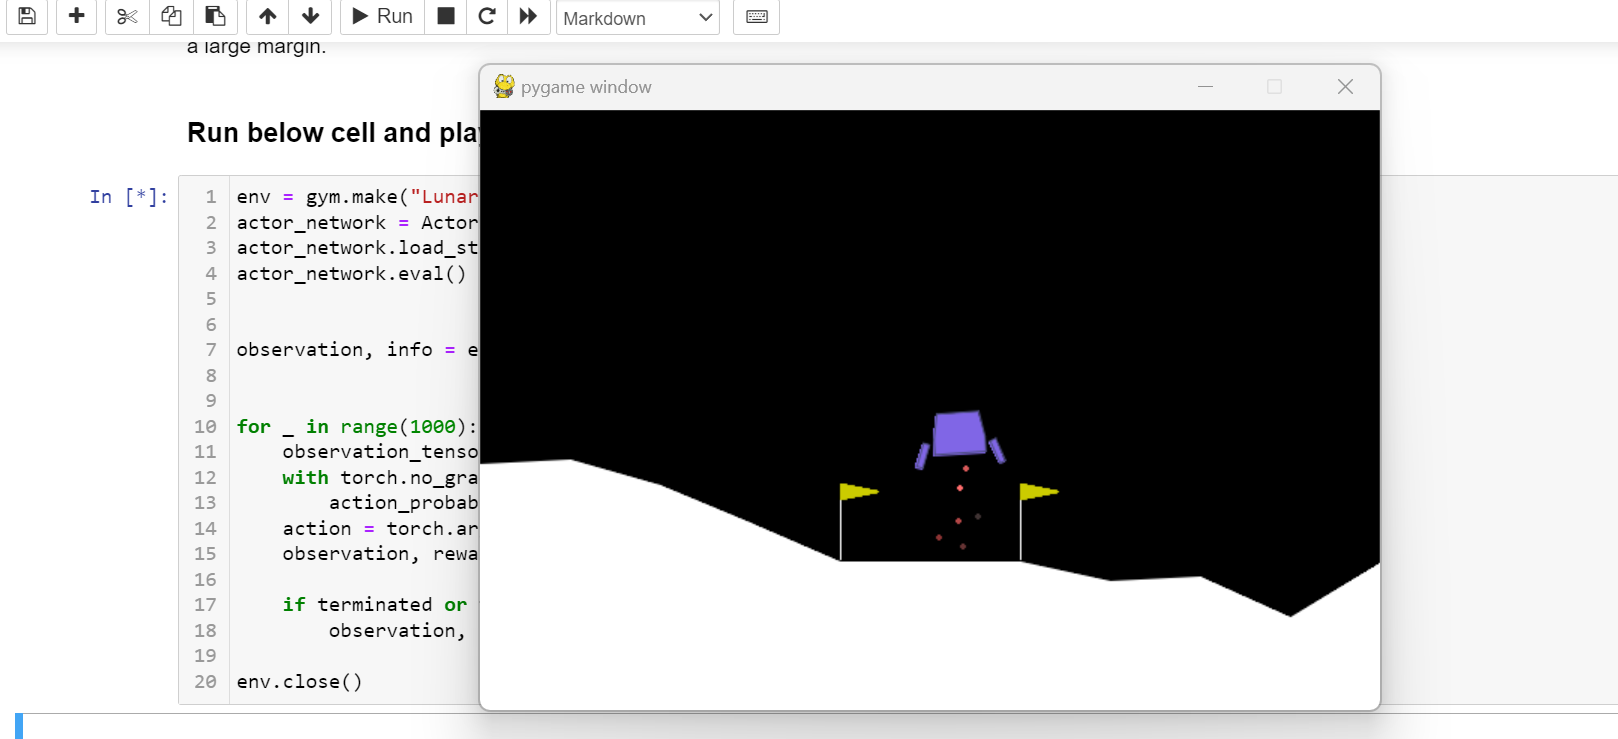

## -----------------------------------------------------------------------------------------------------------------------------

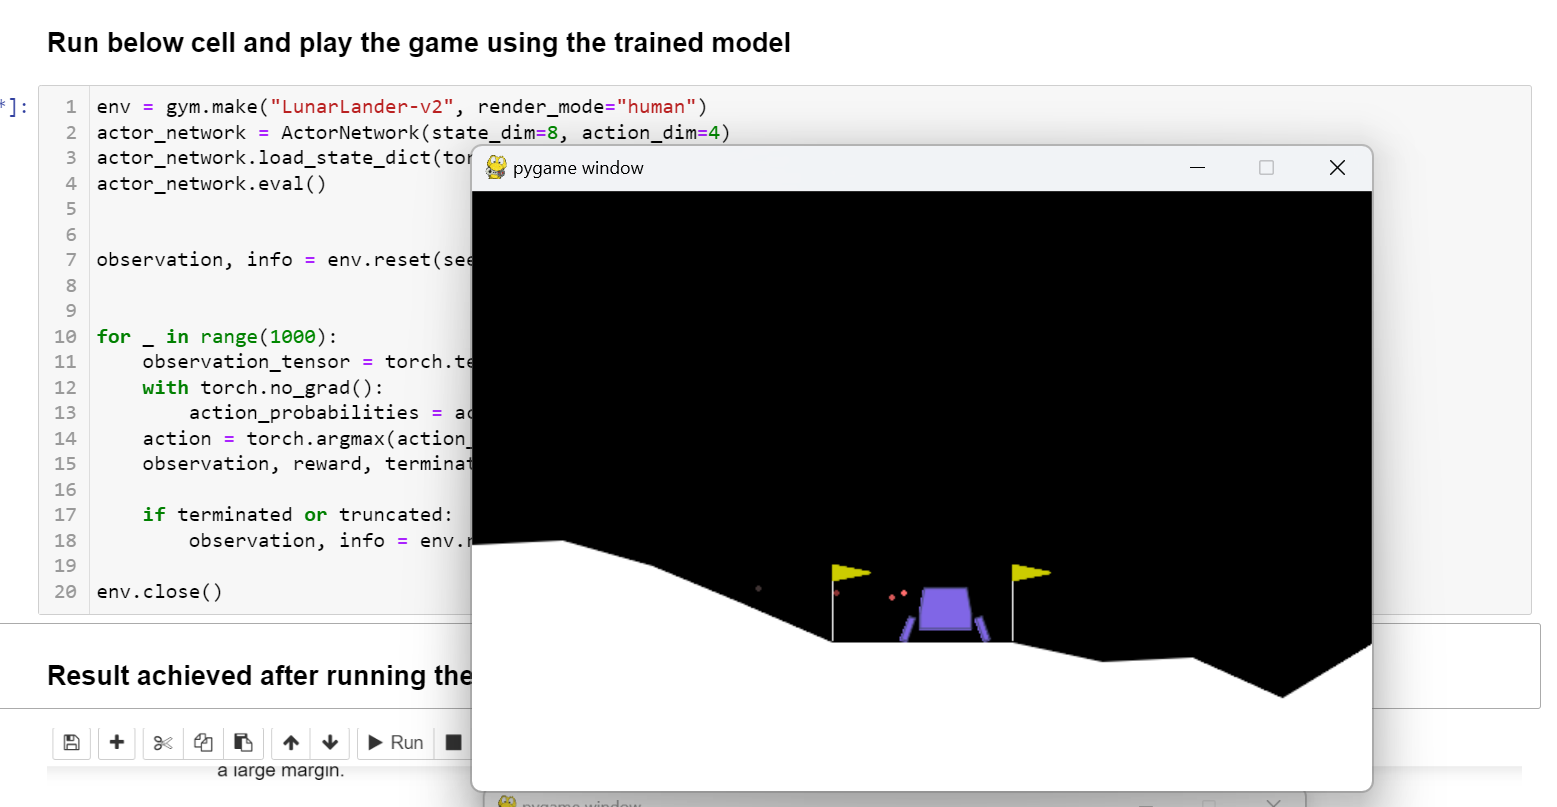